In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Load Dataset

In [ ]:
!kaggle datasets download -d ahmedashrafahmed/bone-fracture

Dataset URL: https://www.kaggle.com/datasets/ahmedashrafahmed/bone-fracture
License(s): unknown
 83% 73.0M/88.4M [00:00<00:00, 141MB/s]
100% 88.4M/88.4M [00:00<00:00, 146MB/s]


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

#Load Images

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/bone-fracture.zip")
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
train_ds= keras.utils.image_dataset_from_directory(
    directory="/content/dataset/train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256)
)

Found 4097 files belonging to 2 classes.


In [ ]:
test_ds= keras.utils.image_dataset_from_directory(
    directory="/content/dataset/test",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256)
)

Found 399 files belonging to 2 classes.


In [ ]:
val_ds= keras.utils.image_dataset_from_directory(
    directory="/content/dataset/val",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256)
)

Found 404 files belonging to 2 classes.


#Read Data

In [ ]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [ ]:
train=data('/content/dataset/train')
train.head()

image          label
0  /content/dataset/train/not fractured/13-rotate...  not fractured
1  /content/dataset/train/not fractured/30-rotate...  not fractured
2  /content/dataset/train/not fractured/41-rotate...  not fractured
3  /content/dataset/train/not fractured/22-rotate...  not fractured
4  /content/dataset/train/not fractured/25-rotate...  not fractured

In [ ]:
test=data('/content/dataset/test')
test.head()

image          label
0  /content/dataset/test/not fractured/21-rotated...  not fractured
1  /content/dataset/test/not fractured/13-rotated...  not fractured
2  /content/dataset/test/not fractured/1-rotated2...  not fractured
3  /content/dataset/test/not fractured/3-rotated1...  not fractured
4  /content/dataset/test/not fractured/28-rotated...  not fractured

In [ ]:
val=data('/content/dataset/val')
val.head()

image          label
0  /content/dataset/val/not fractured/34-rotated2...  not fractured
1  /content/dataset/val/not fractured/6-rotated2-...  not fractured
2  /content/dataset/val/not fractured/5-rotated3-...  not fractured
3  /content/dataset/val/not fractured/33-rotated1...  not fractured
4  /content/dataset/val/not fractured/22-rotated2...  not fractured

#Visualization of Dataset

In [ ]:
def process(image,label):
  image= tf.cast(image/255. ,tf.float32)
  return image,label
train_ds=train_ds.map(process)
test_ds=test_ds.map(process)

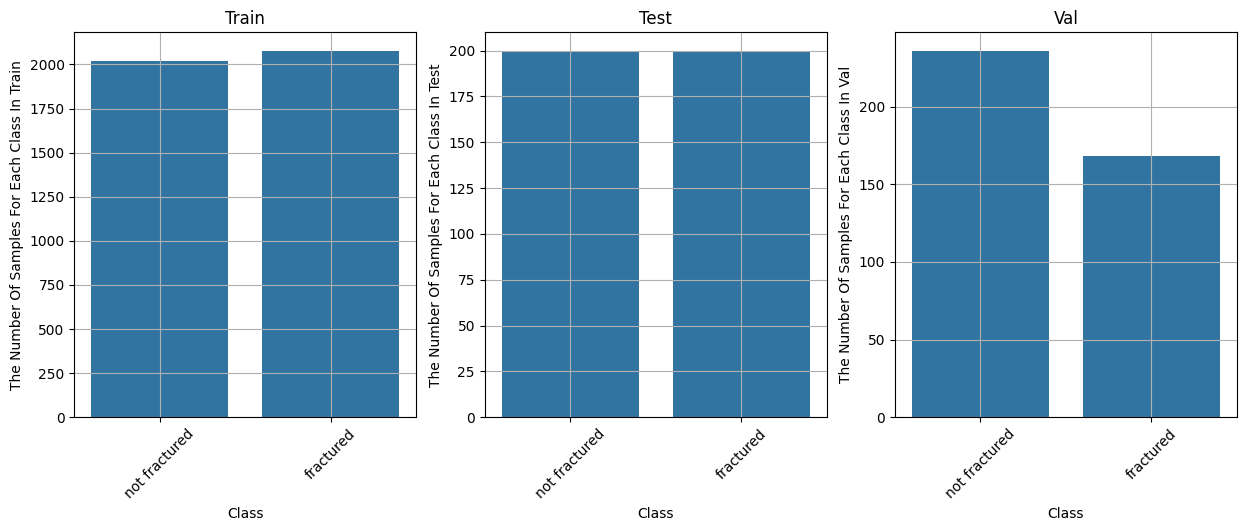

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,2)
ax = sns.countplot(x=test.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,3)
ax = sns.countplot(x=val.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Val")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

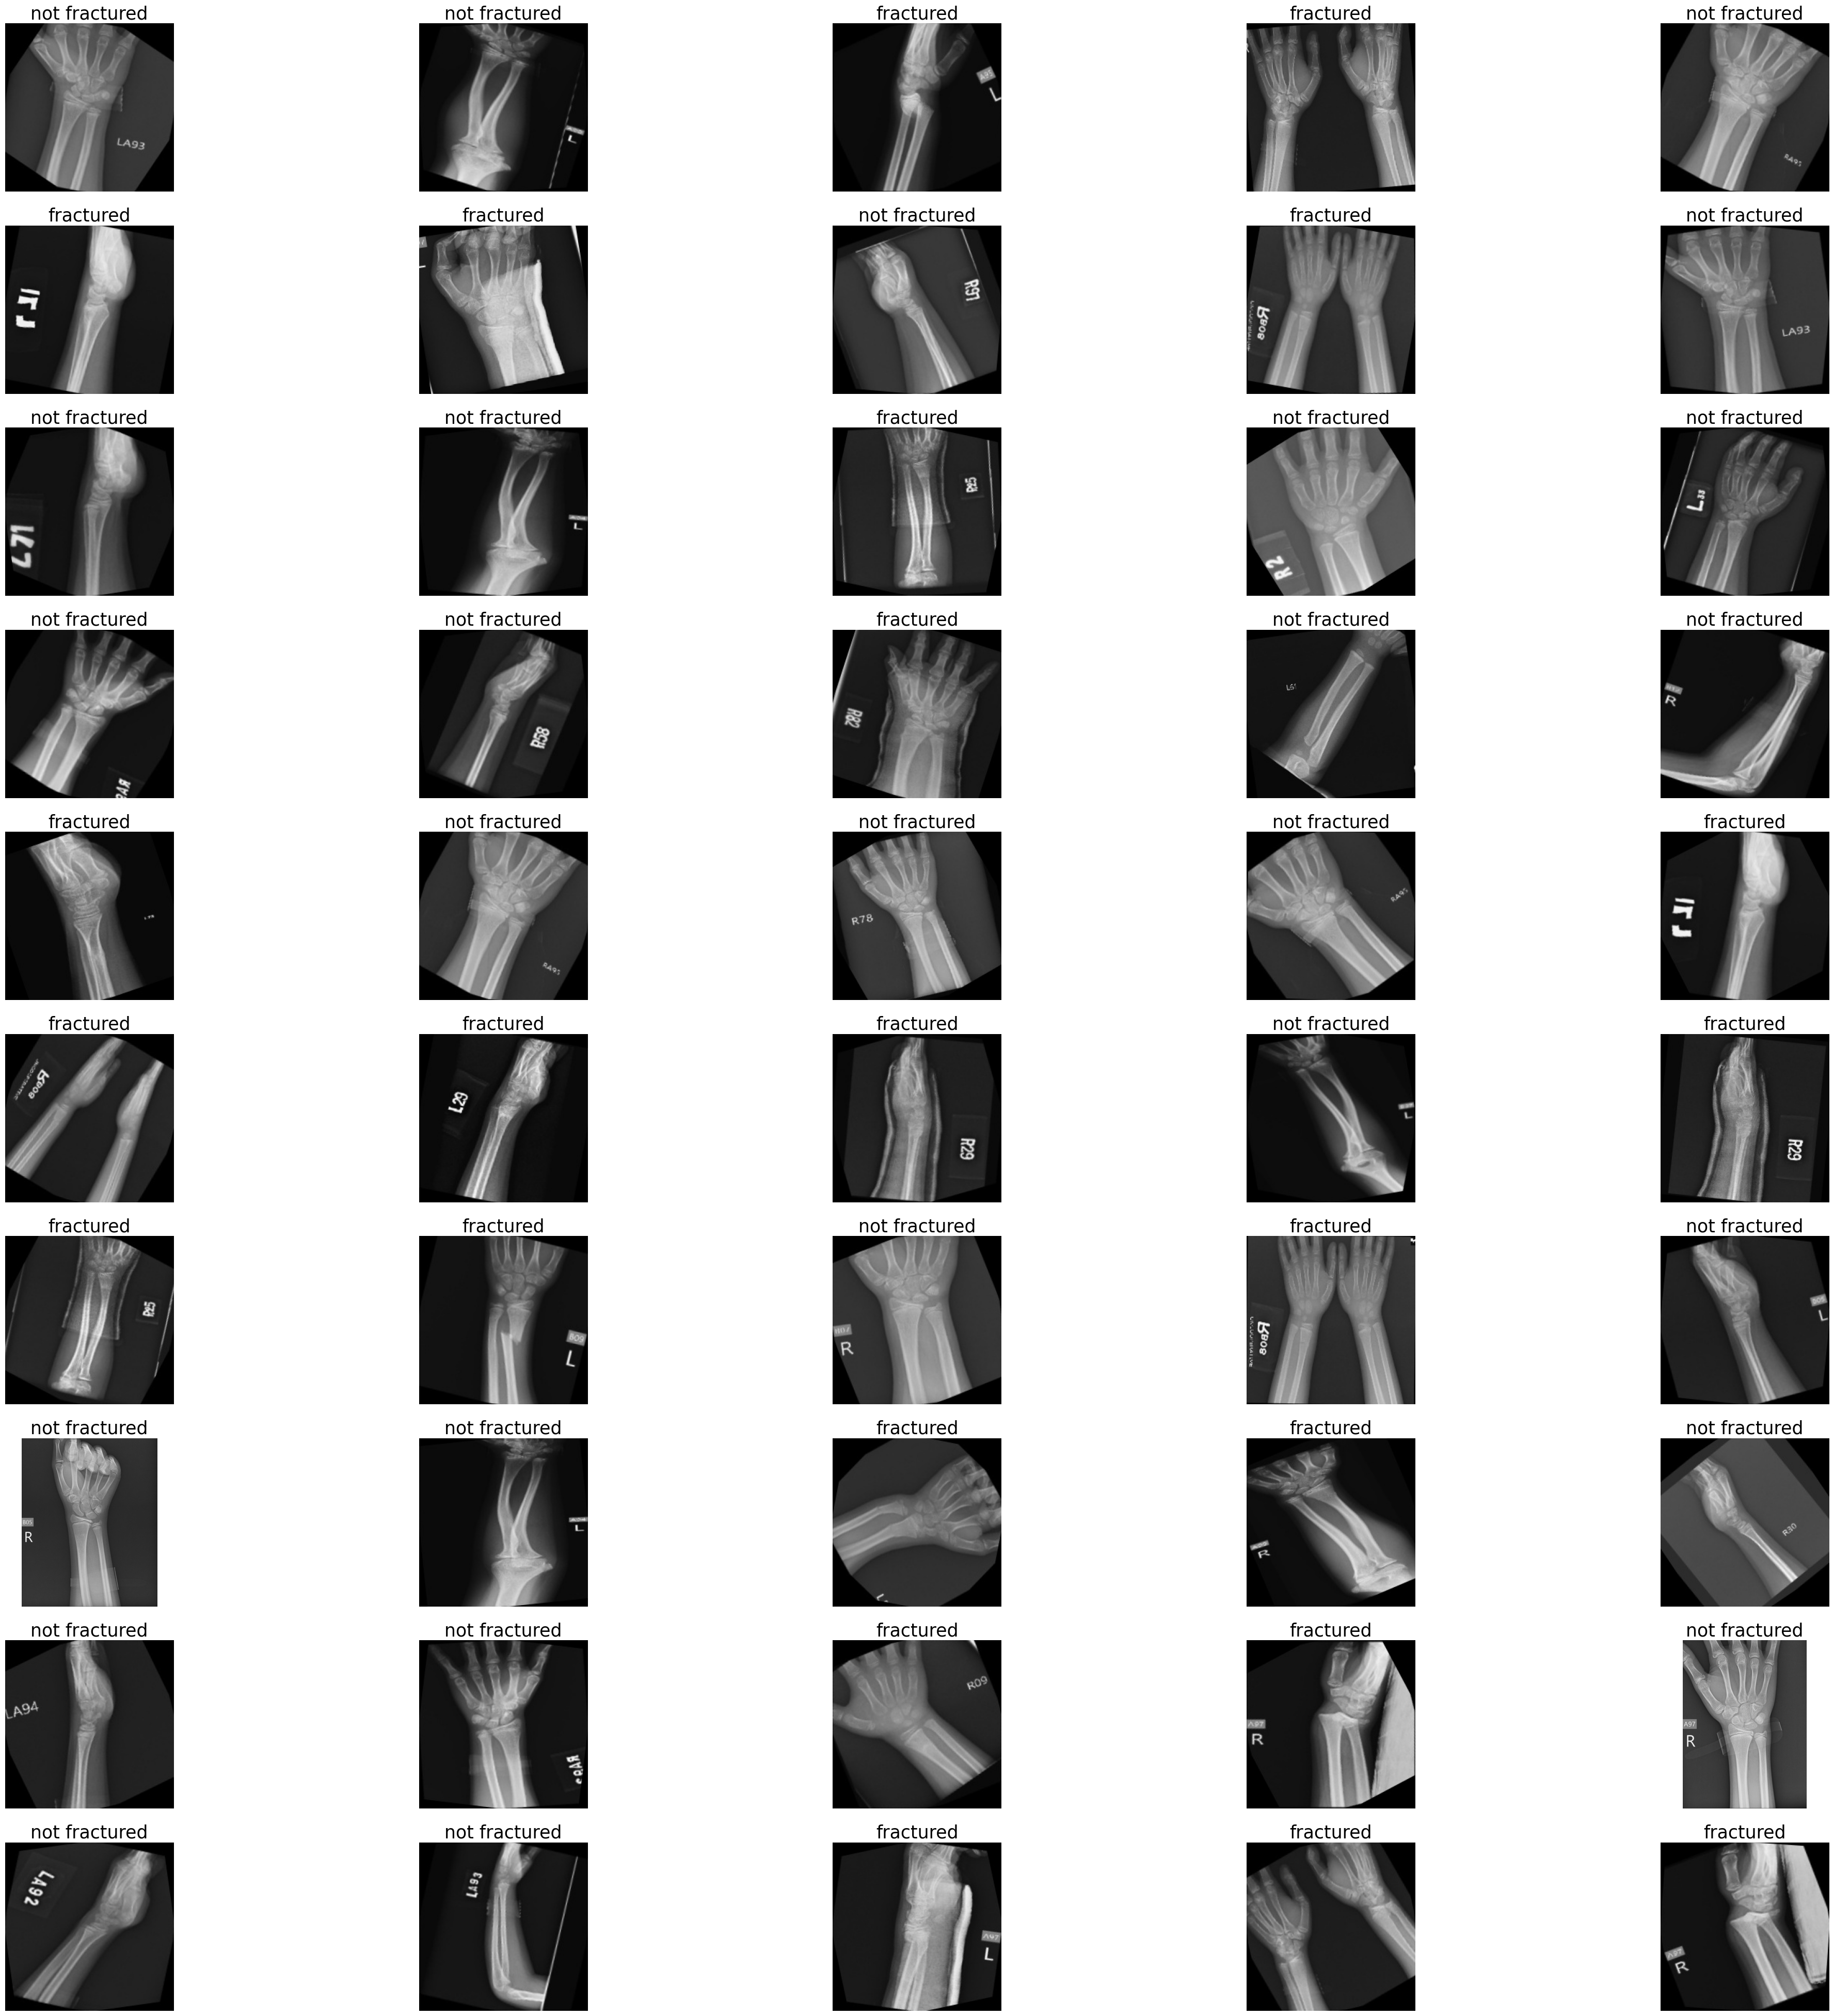

In [ ]:
import cv2
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

#Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


#Modeling

In [ ]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,278,593 (84.99 MB)

 Trainable params: 22,278,145 (84.98 MB)

 Non-trainable params: 448 (1.75 KB)

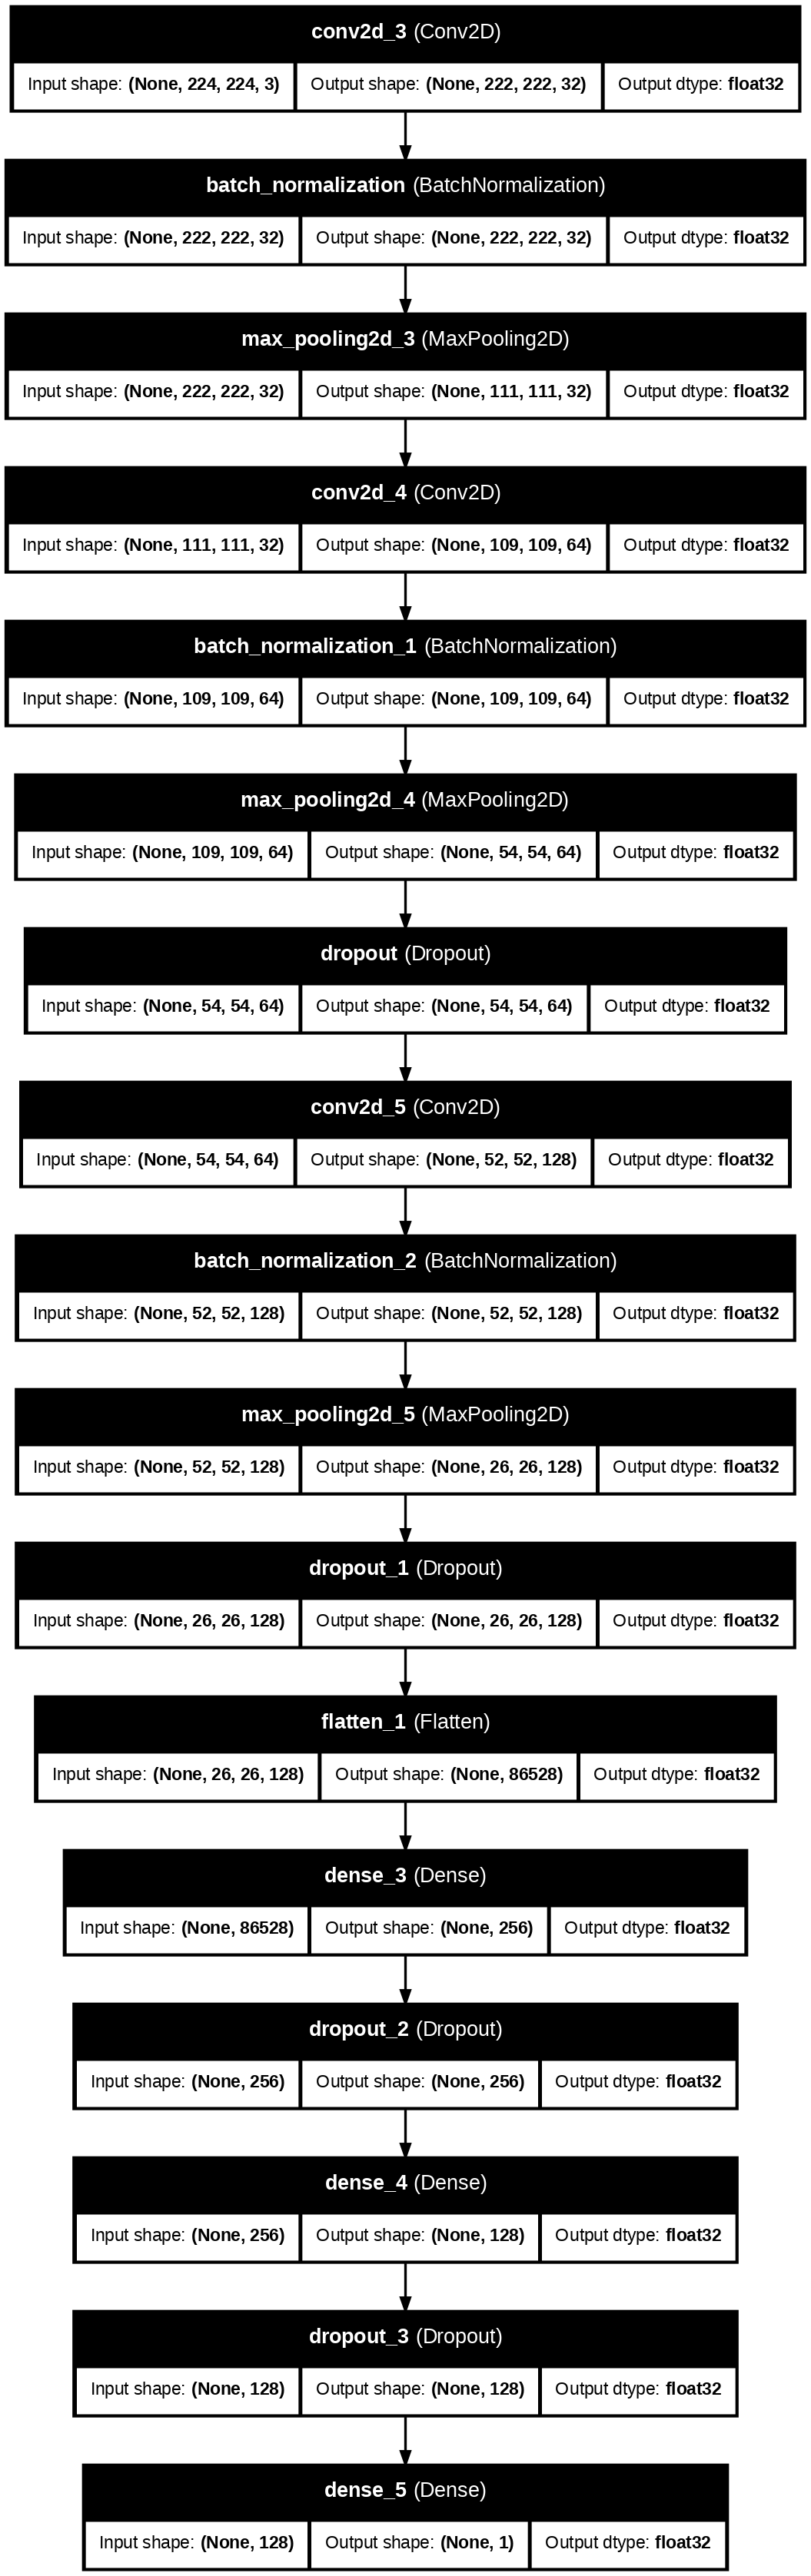

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Change the file extension to '.keras'
checkpoint_cb =ModelCheckpoint("my_keras_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])

# Use model.fit instead of model.fit_generator
hist=model.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 733s 6s/step - accuracy: 0.6251 - auc_1: 0.6601 - loss: 5.6242 - specificity_at_sensitivity_1: 0.7142 - val_accuracy: 0.5842 - val_auc_1: 0.5000 - val_loss: 20.9777 - val_specificity_at_sensitivity_1: 0.0000e+00
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 722s 6s/step - accuracy: 0.8240 - auc_1: 0.8903 - loss: 0.9670 - specificity_at_sensitivity_1: 0.9398 - val_accuracy: 0.5842 - val_auc_1: 0.5030 - val_loss: 12.1957 - val_specificity_at_sensitivity_1: 0.0060
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 719s 6s/step - accuracy: 0.8708 - auc_1: 0.9301 - loss: 0.6430 - specificity_at_sensitivity_1: 0.9562 - val_accuracy: 0.5916 - val_auc_1: 0.5119 - val_loss: 17.3767 - val_specificity_at_sensitivity_1: 0.0238
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 726s 6s/step - accuracy: 0.8953 - auc_1: 0.9608 - loss: 0.3472 - specificity_at_sensitivity_1: 0.9867 - val_accuracy: 0.7104 - val_auc_1: 0.6682 - val_loss: 7.0705 - val_specificity_at_sensitivity_1: 0.3750
Epoch 5/10
129/1

#Evaluate The Model

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy     auc_1      loss  specificity_at_sensitivity_1  val_accuracy  \
0  0.712228  0.758977  3.290035                      0.828681      0.584158   
1  0.832316  0.895284  0.947371                      0.937440      0.584158   
2  0.870881  0.935868  0.564966                      0.963426      0.591584   
3  0.905541  0.967068  0.297981                      0.989413      0.710396   
4  0.936051  0.980440  0.196973                      0.991338      0.955446   
5  0.952160  0.988060  0.149506                      0.994225      0.992574   
6  0.960947  0.990843  0.122035                      0.997113      0.995049   
7  0.963144  0.990306  0.118994                      0.993744      0.997525   
8  0.972419  0.991435  0.110105                      0.992782      0.985148   
9  0.967049  0.991952  0.116501                      0.996150      0.992574   

   val_auc_1   val_loss  val_specificity_at_sensitivity_1  
0   0.500000  20.977726                          0.000000  
1   0.502976  12.195709                          0.005952  
2   0.511905  17.376705                          0.023810  
3   0.668218   7.070466                          0.375000  
4   0.993329   0.115408                          0.994048  
5   0.999899   0.015595                          1.000000  
6   0.999975   0.009440                          1.000000  
7   0.999899   0.013828                          1.000000  
8   0.990743   0.094565                          0.982143  
9   0.999786   0.019315                          1.000000

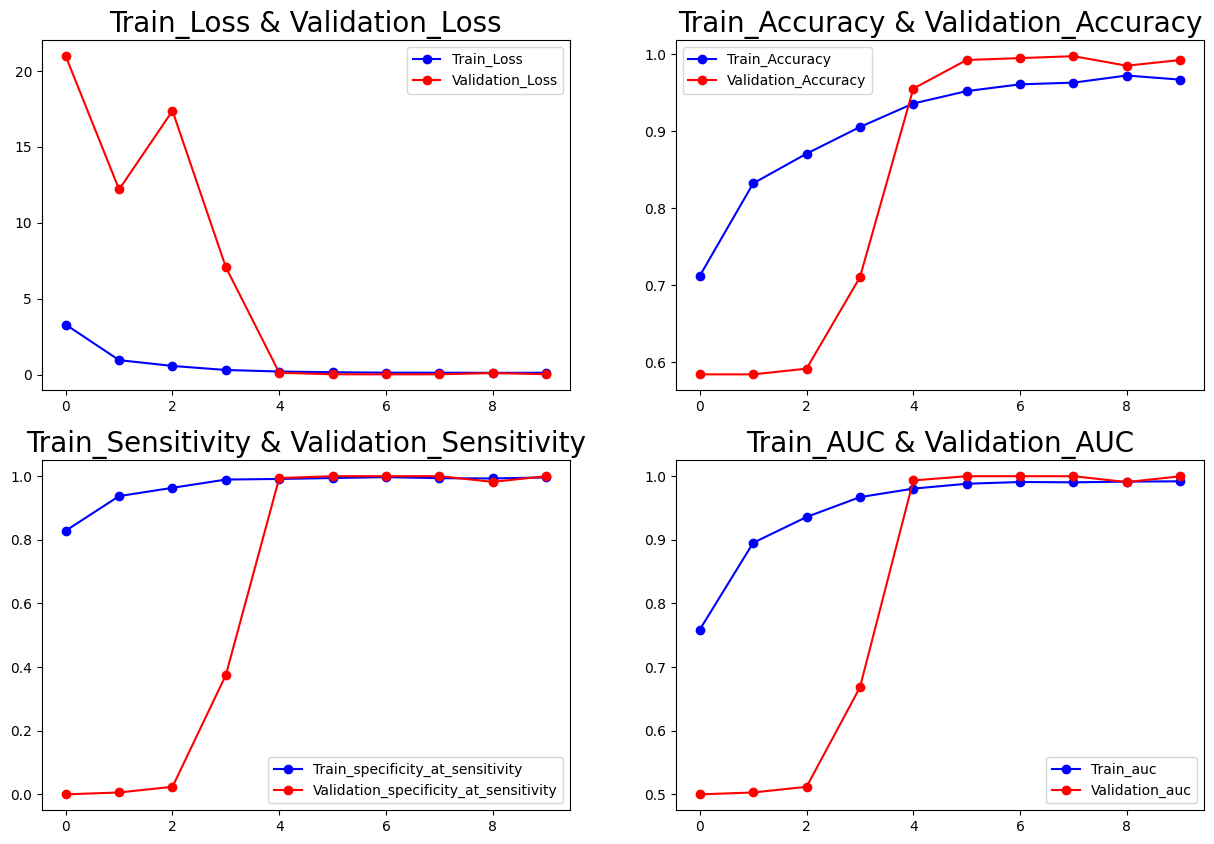

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
# Access the correct column name for specificity at sensitivity
plt.plot(hist_['specificity_at_sensitivity_1'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity_1'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
# Use the correct column name for AUC
plt.plot(hist_['auc_1'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc_1'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9759 - auc_1: 0.5692 - loss: 0.0838 - specificity_at_sensitivity_1: 0.5714
Test Loss = 0.06800572574138641
Test Accuracy = 0.9824561476707458
Test Sensitivity = 1.0
Test AUC = 0.9965201020240784


In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


Actual  Prediction
0         1           1
1         1           1
2         1           1
3         1           1
4         1           1
..      ...         ...
394       0           0
395       0           0
396       0           0
397       0           0
398       0           0

[399 rows x 2 columns]

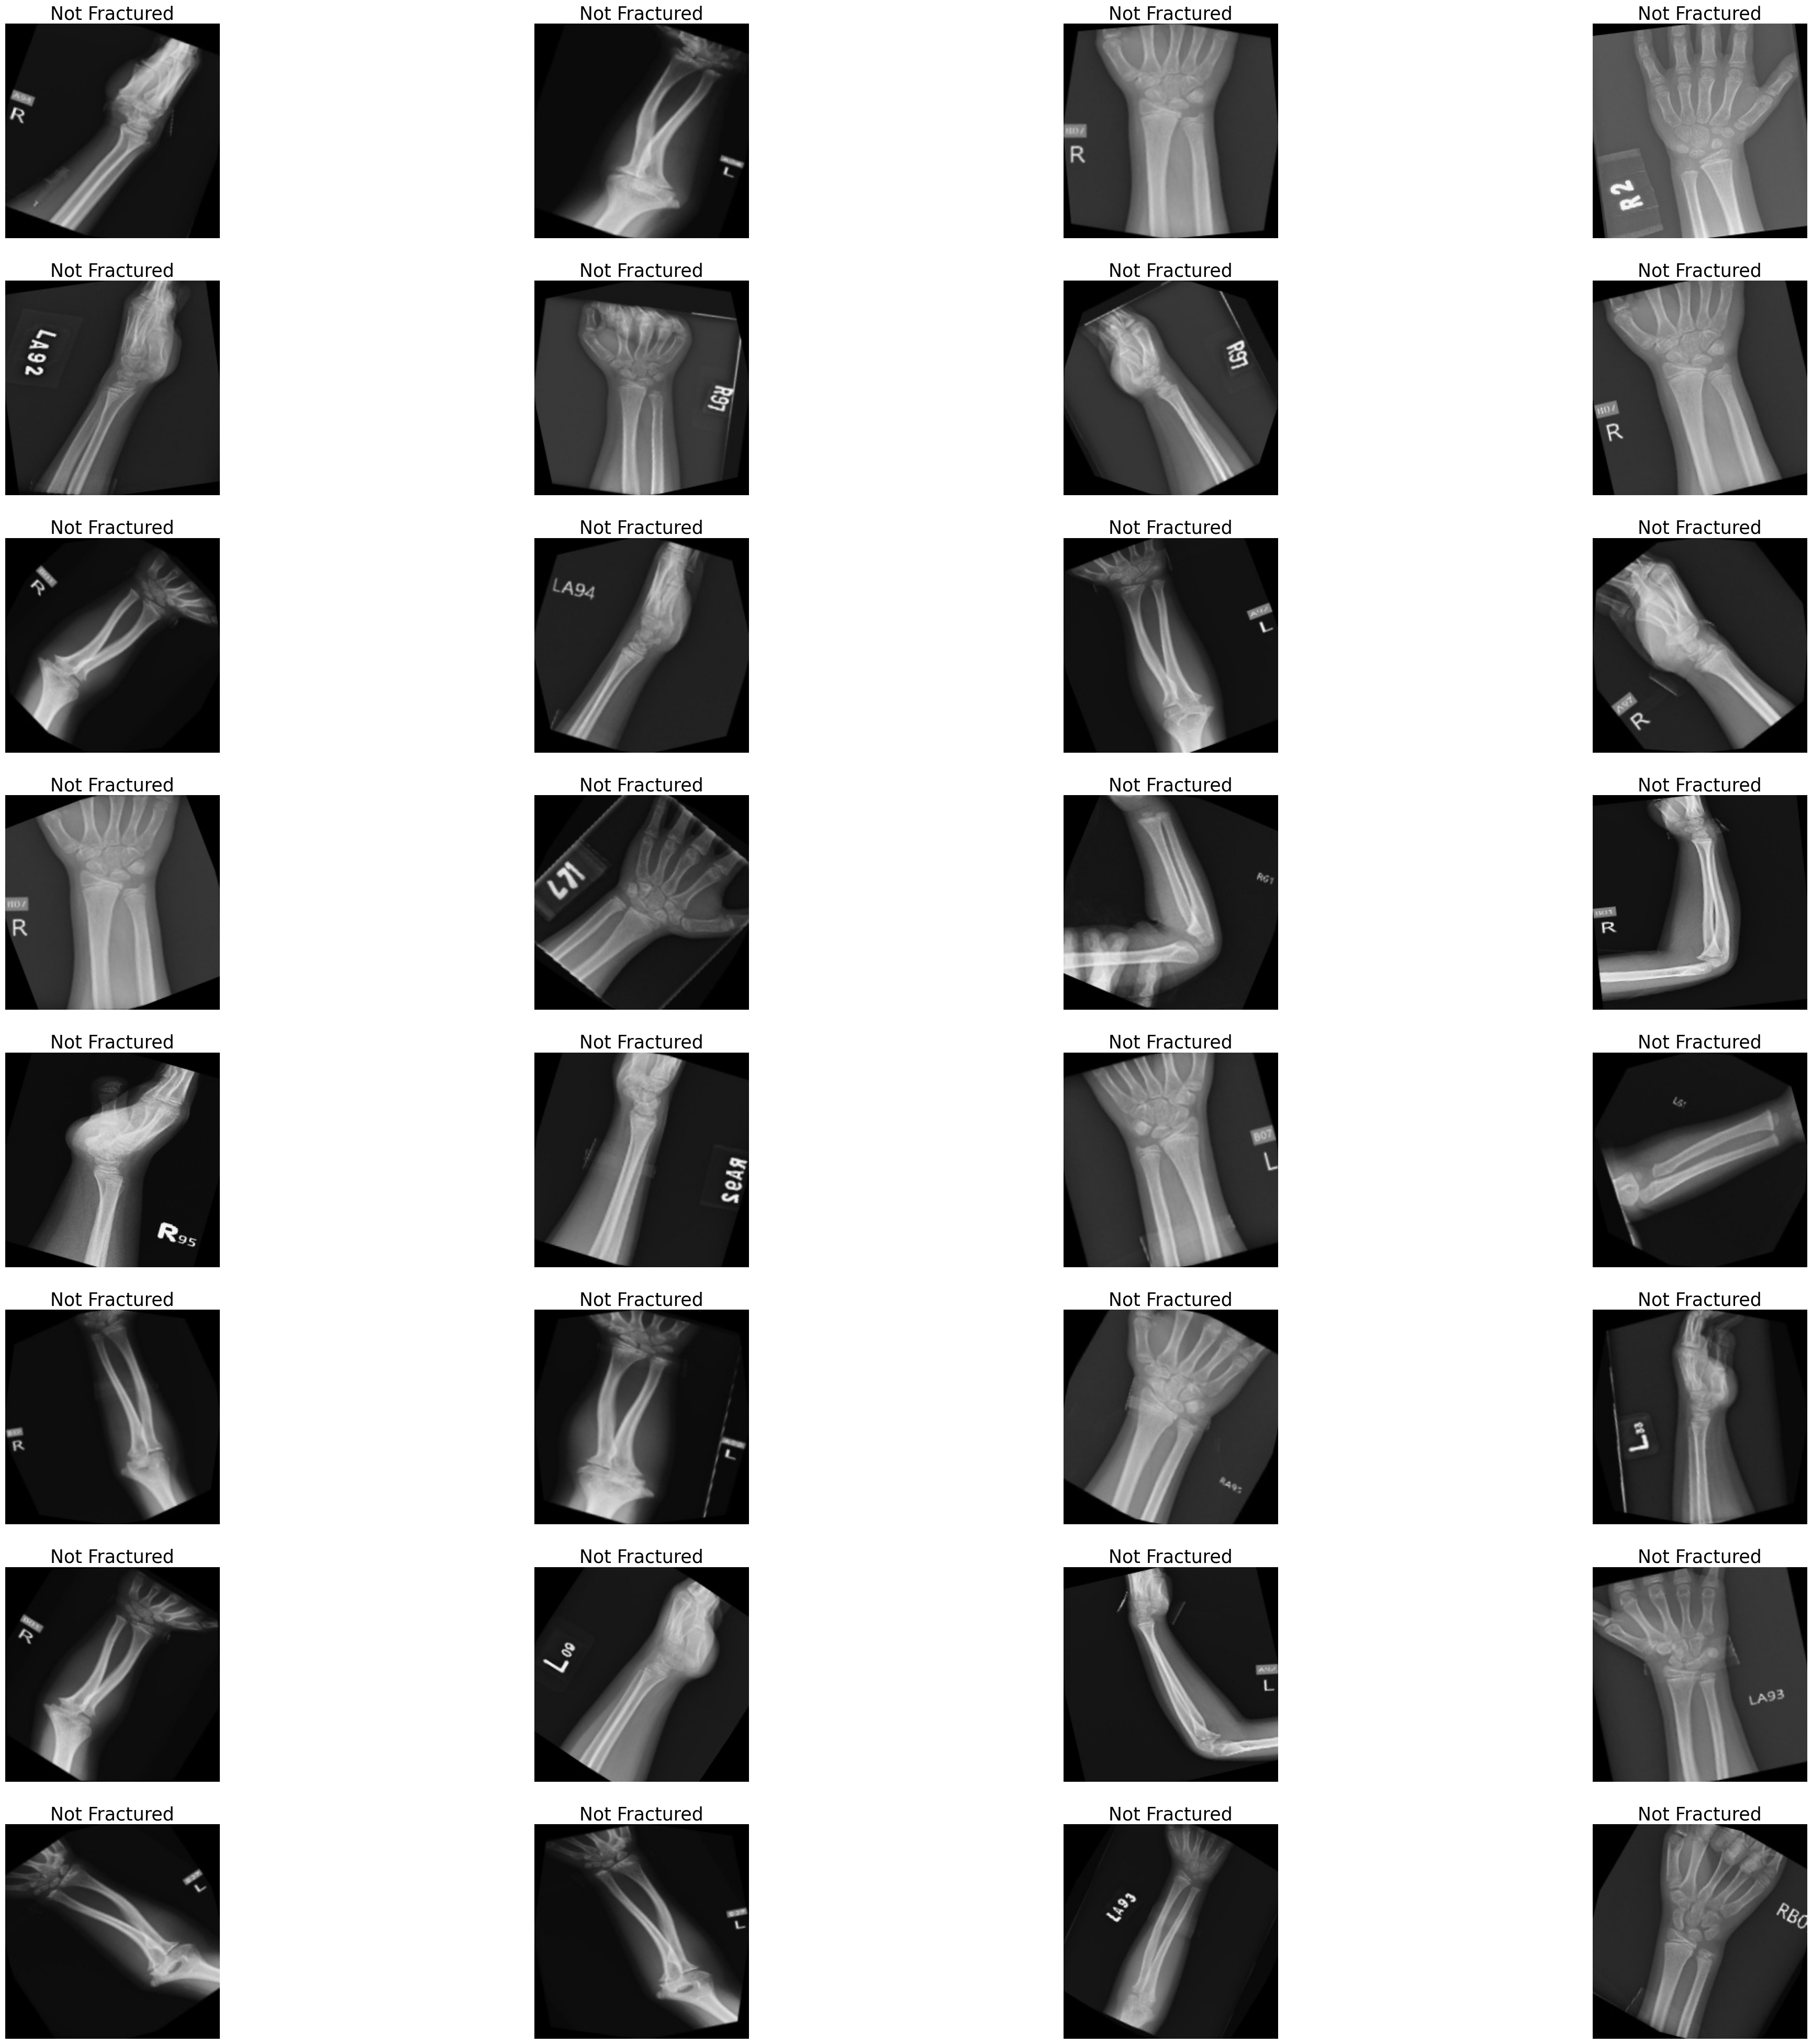

In [ ]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

array([[197,   2],
       [  5, 195]])

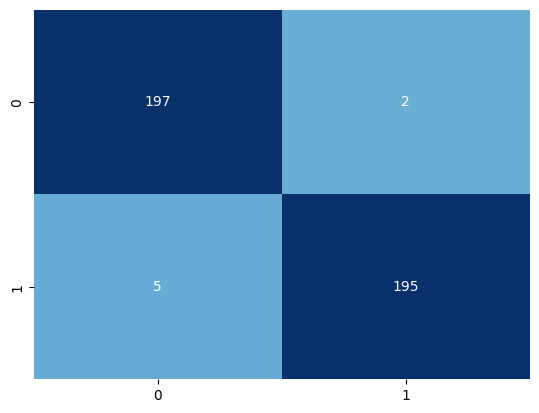

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.98      0.99      0.98       199
           1       0.99      0.97      0.98       200

    accuracy                           0.98       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.98      0.98       399



In [ ]:
def predict_image(image_path):
    image_size = (224, 224)
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img)
    return 'Fractured' if prediction <= 0.5 else 'Not Fractured'


image_path = '/content/dataset/test/fractured/1-rotated1-rotated2-rotated1.jpg'
result = predict_image(image_path)
print(f'The image is: {result}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
The image is: Fractured


In [ ]:
def predict_image(image_path):
    image_size = (224, 224)
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img)
    return 'Fractured' if prediction <= 0.5 else 'Not Fractured'


image_path = '/content/dataset/train/not fractured/1-rotated1-rotated1-rotated2-rotated1.jpg'
result = predict_image(image_path)
print(f'The image is: {result}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
The image is: Not Fractured
